# Detecting AI Generated Fake Images

# Computer Vision Semester Project Spring 2025

## Team: Muhammad Ali Raza (011), Mohammad Ammar Siddique (041), Ali Hamza (032)

# 1. Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, InceptionV3, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image

import cv2


2025-06-16 18:40:29.855012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750099230.052837      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750099230.105843      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Sample Images

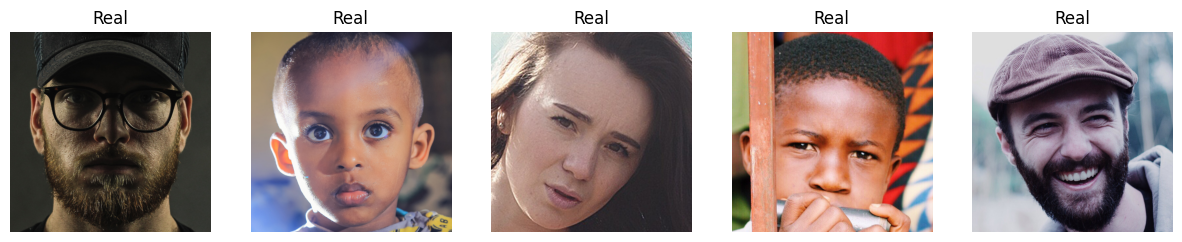

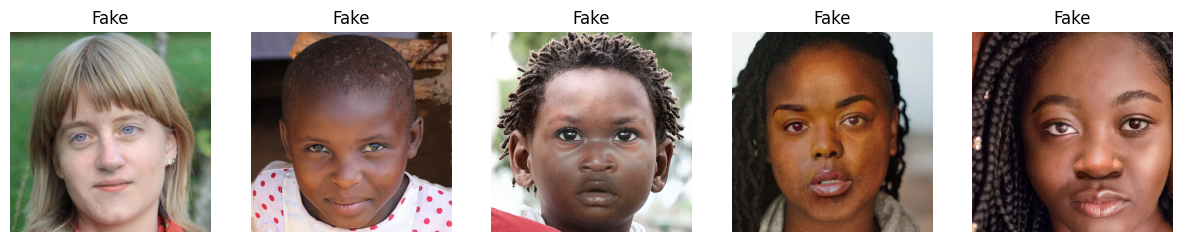

In [2]:
def show_sample_images(path, label, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    image_files = os.listdir(path)[:n]
    for i, img_file in enumerate(image_files):
        img = plt.imread(os.path.join(path, img_file))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(label)
    plt.show()

real_path = "../input/real-and-fake-face-detection/real_and_fake_face/training_real/"
fake_path = "../input/real-and-fake-face-detection/real_and_fake_face/training_fake/"
dataset_path = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face"


show_sample_images(real_path, "Real")
show_sample_images(fake_path, "Fake")


# 3. Data Augmentation

In [3]:
model_input_shapes = {
    "MobileNetV2": (96, 96),
    "VGG16": (224, 224),
    "InceptionV3": (299, 299),
    "ResNet50": (224, 224),
    "EfficientNetB0": (224, 224),
}


def get_data_generators(model_name, batch_size=32):
    target_size = model_input_shapes[model_name]

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2]
    )

    train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=target_size,
        class_mode='binary',
        subset='training',
        batch_size=batch_size,
        shuffle=True
    )

    val_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=target_size,
        class_mode='binary',
        subset='validation',
        batch_size=batch_size,
        shuffle=False
    )

    return train_generator, val_generator, target_size

# 4. Model Builder

In [4]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import tempfile
from PIL import Image

def get_model(model_name, input_shape):
    if model_name == "MobileNetV2":
        base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == "VGG16":
        base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == "ResNet50":
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == "EfficientNetB0":
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError("Unknown model name")

    base_model.trainable = True
    for layer in base_model.layers[:-30]:  # freeze all but last ~30 layers
        layer.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)

        
            
    return model

#  5. Model Training

In [5]:
import matplotlib.pyplot as plt

model_names = ["MobileNetV2", "VGG16", "InceptionV3", "ResNet50", "EfficientNetB0"]
results = {}
best_models = {}
histories = {}

for name in model_names:
    print(f"\n🔧 Training {name}...")
    train_data, val_data, shape = get_data_generators(name, batch_size=32)
    input_shape = (*shape, 3)
    model = get_model(name, input_shape)

    model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, validation_data=val_data, epochs=10)

    final_train_acc = history.history['accuracy'][-1]

    results[name] = {
        "train_accuracy": final_train_acc
    }

    best_models[name] = model
    model.save("/kaggle/working/model.h5")
    val_loss, val_accuracy = model.evaluate(val_data)
    results[name]["val_accuracy"] = val_accuracy

    
    histories[name] = history


🔧 Training MobileNetV2...
Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


I0000 00:00:1750099275.948525      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1750099292.525633     115 service.cc:148] XLA service 0x34f931d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750099292.526303     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750099293.894534     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1750099296.161386     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750099296.344253     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750099296.606805     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750099296.810563  

 1/52 ━━━━━━━━━━━━━━━━━━━━ 18:00 21s/step - accuracy: 0.5625 - loss: 0.7726

I0000 00:00:1750099300.334243     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 ━━━━━━━━━━━━━━━━━━━━ 58s 719ms/step - accuracy: 0.5445 - loss: 0.7660 - val_accuracy: 0.5245 - val_loss: 0.9092
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.5718 - loss: 0.6945 - val_accuracy: 0.5098 - val_loss: 0.8547
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 388ms/step - accuracy: 0.6500 - loss: 0.6433 - val_accuracy: 0.4975 - val_loss: 0.8022
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 386ms/step - accuracy: 0.6327 - loss: 0.6403 - val_accuracy: 0.5025 - val_loss: 0.7941
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - accuracy: 0.6566 - loss: 0.6085 - val_accuracy: 0.5172 - val_loss: 0.8042
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 381ms/step - accuracy: 0.6641 - loss: 0.6122 - val_accuracy: 0.5147 - val_loss: 0.7890
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 378ms/step - accuracy: 0.6987 - loss: 0.5857 - val_accuracy: 0.4951 - val_loss: 0.8023
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 0.6933 - loss: 0.5802 - val_accuracy: 0.497

E0000 00:00:1750101001.537980     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750101001.743988     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750101002.145331     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750101002.351008     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


25/52 ━━━━━━━━━━━━━━━━━━━━ 14s 548ms/step - accuracy: 0.5341 - loss: 0.6956

E0000 00:00:1750101027.056922     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750101027.244110     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


52/52 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5340 - loss: 0.6959 - val_accuracy: 0.5294 - val_loss: 0.6931
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 696ms/step - accuracy: 0.5043 - loss: 0.6991 - val_accuracy: 0.5294 - val_loss: 0.6916
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 698ms/step - accuracy: 0.5488 - loss: 0.6933 - val_accuracy: 0.5294 - val_loss: 0.6914
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 684ms/step - accuracy: 0.5174 - loss: 0.6926 - val_accuracy: 0.5294 - val_loss: 0.6917
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 697ms/step - accuracy: 0.5312 - loss: 0.6901 - val_accuracy: 0.5294 - val_loss: 0.6928
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 700ms/step - accuracy: 0.4912 - loss: 0.6961 - val_accuracy: 0.4706 - val_loss: 0.6968
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - accuracy: 0.5369 - loss: 0.6909 - val_accuracy: 0.4706 - val_loss: 0.7025
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 688ms/step - accuracy: 0.5248 - loss: 0.6938 - val_accuracy: 0.4706 -

# 6. Model Evaluation

## 6a. Classification Reports

In [19]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

roc_data = {}
conf_matrices = {}

for name in model_names:
    print(f"\n📊 Evaluating {name}...")
    model = best_models[name]

    _, val_data, shape = get_data_generators(name, batch_size=32)

    val_data.reset()
    y_true = val_data.classes
    y_pred_proba = model.predict(val_data).flatten()
    y_pred_class = (y_pred_proba >= 0.5).astype(int)

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

    cm = confusion_matrix(y_true, y_pred_class)
    conf_matrices[name] = cm

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred_class, target_names=['Fake', 'Real']))



📊 Evaluating MobileNetV2...
Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step

Classification Report for MobileNetV2:
              precision    recall  f1-score   support

        Fake       0.45      0.31      0.36       192
        Real       0.52      0.66      0.58       216

    accuracy                           0.50       408
   macro avg       0.48      0.48      0.47       408
weighted avg       0.48      0.50      0.48       408


📊 Evaluating VGG16...
Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step

Classification Report for VGG16:
              precision    recall  f1-score   support

        Fake       0.55      0.47      0.51       192
        Real       0.58      0.65      0.62       216

    accuracy                           0.57       408
   macro avg       0.57      0.56      0.56       408
weighted avg       0.57      0.57      0.57       408


📊 Evaluating InceptionV3...
Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 826ms/step

Classification Report for InceptionV3:
              precision    recall  f1-score   support

        Fake       0.41      0.26      0.31       192
        Real       0.50      0.67      0.58       216

    accuracy                           0.48       408
   macro avg       0.46      0.46      0.44       408
weighted avg       0.46      0.48      0.45       408


📊 Evaluating ResNet50...
Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 546ms/step

Classification Report for ResNet50:
              precision    recall  f1-score   support

        Fake       0.54      0.14      0.22       192
        Real       0.54      0.89      0.67       216

    accuracy                           0.54       408
   macro avg       0.54      0.52      0.45       408
weighted avg       0.54      0.54      0.46       408


📊 Evaluating EfficientNetB0...
Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 547ms/step

Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

        Fake       0.60      0.02      0.03       192
        Real       0.53      0.99      0.69       216

    accuracy                           0.53       408
   macro avg       0.57      0.50      0.36       408
weighted avg       0.56      0.53      0.38       408



## 6b. ROC-AUC Curves

MobileNetV2: 0.49
VGG16: 0.57
InceptionV3: 0.50
ResNet50: 0.56
EfficientNetB0: 0.50


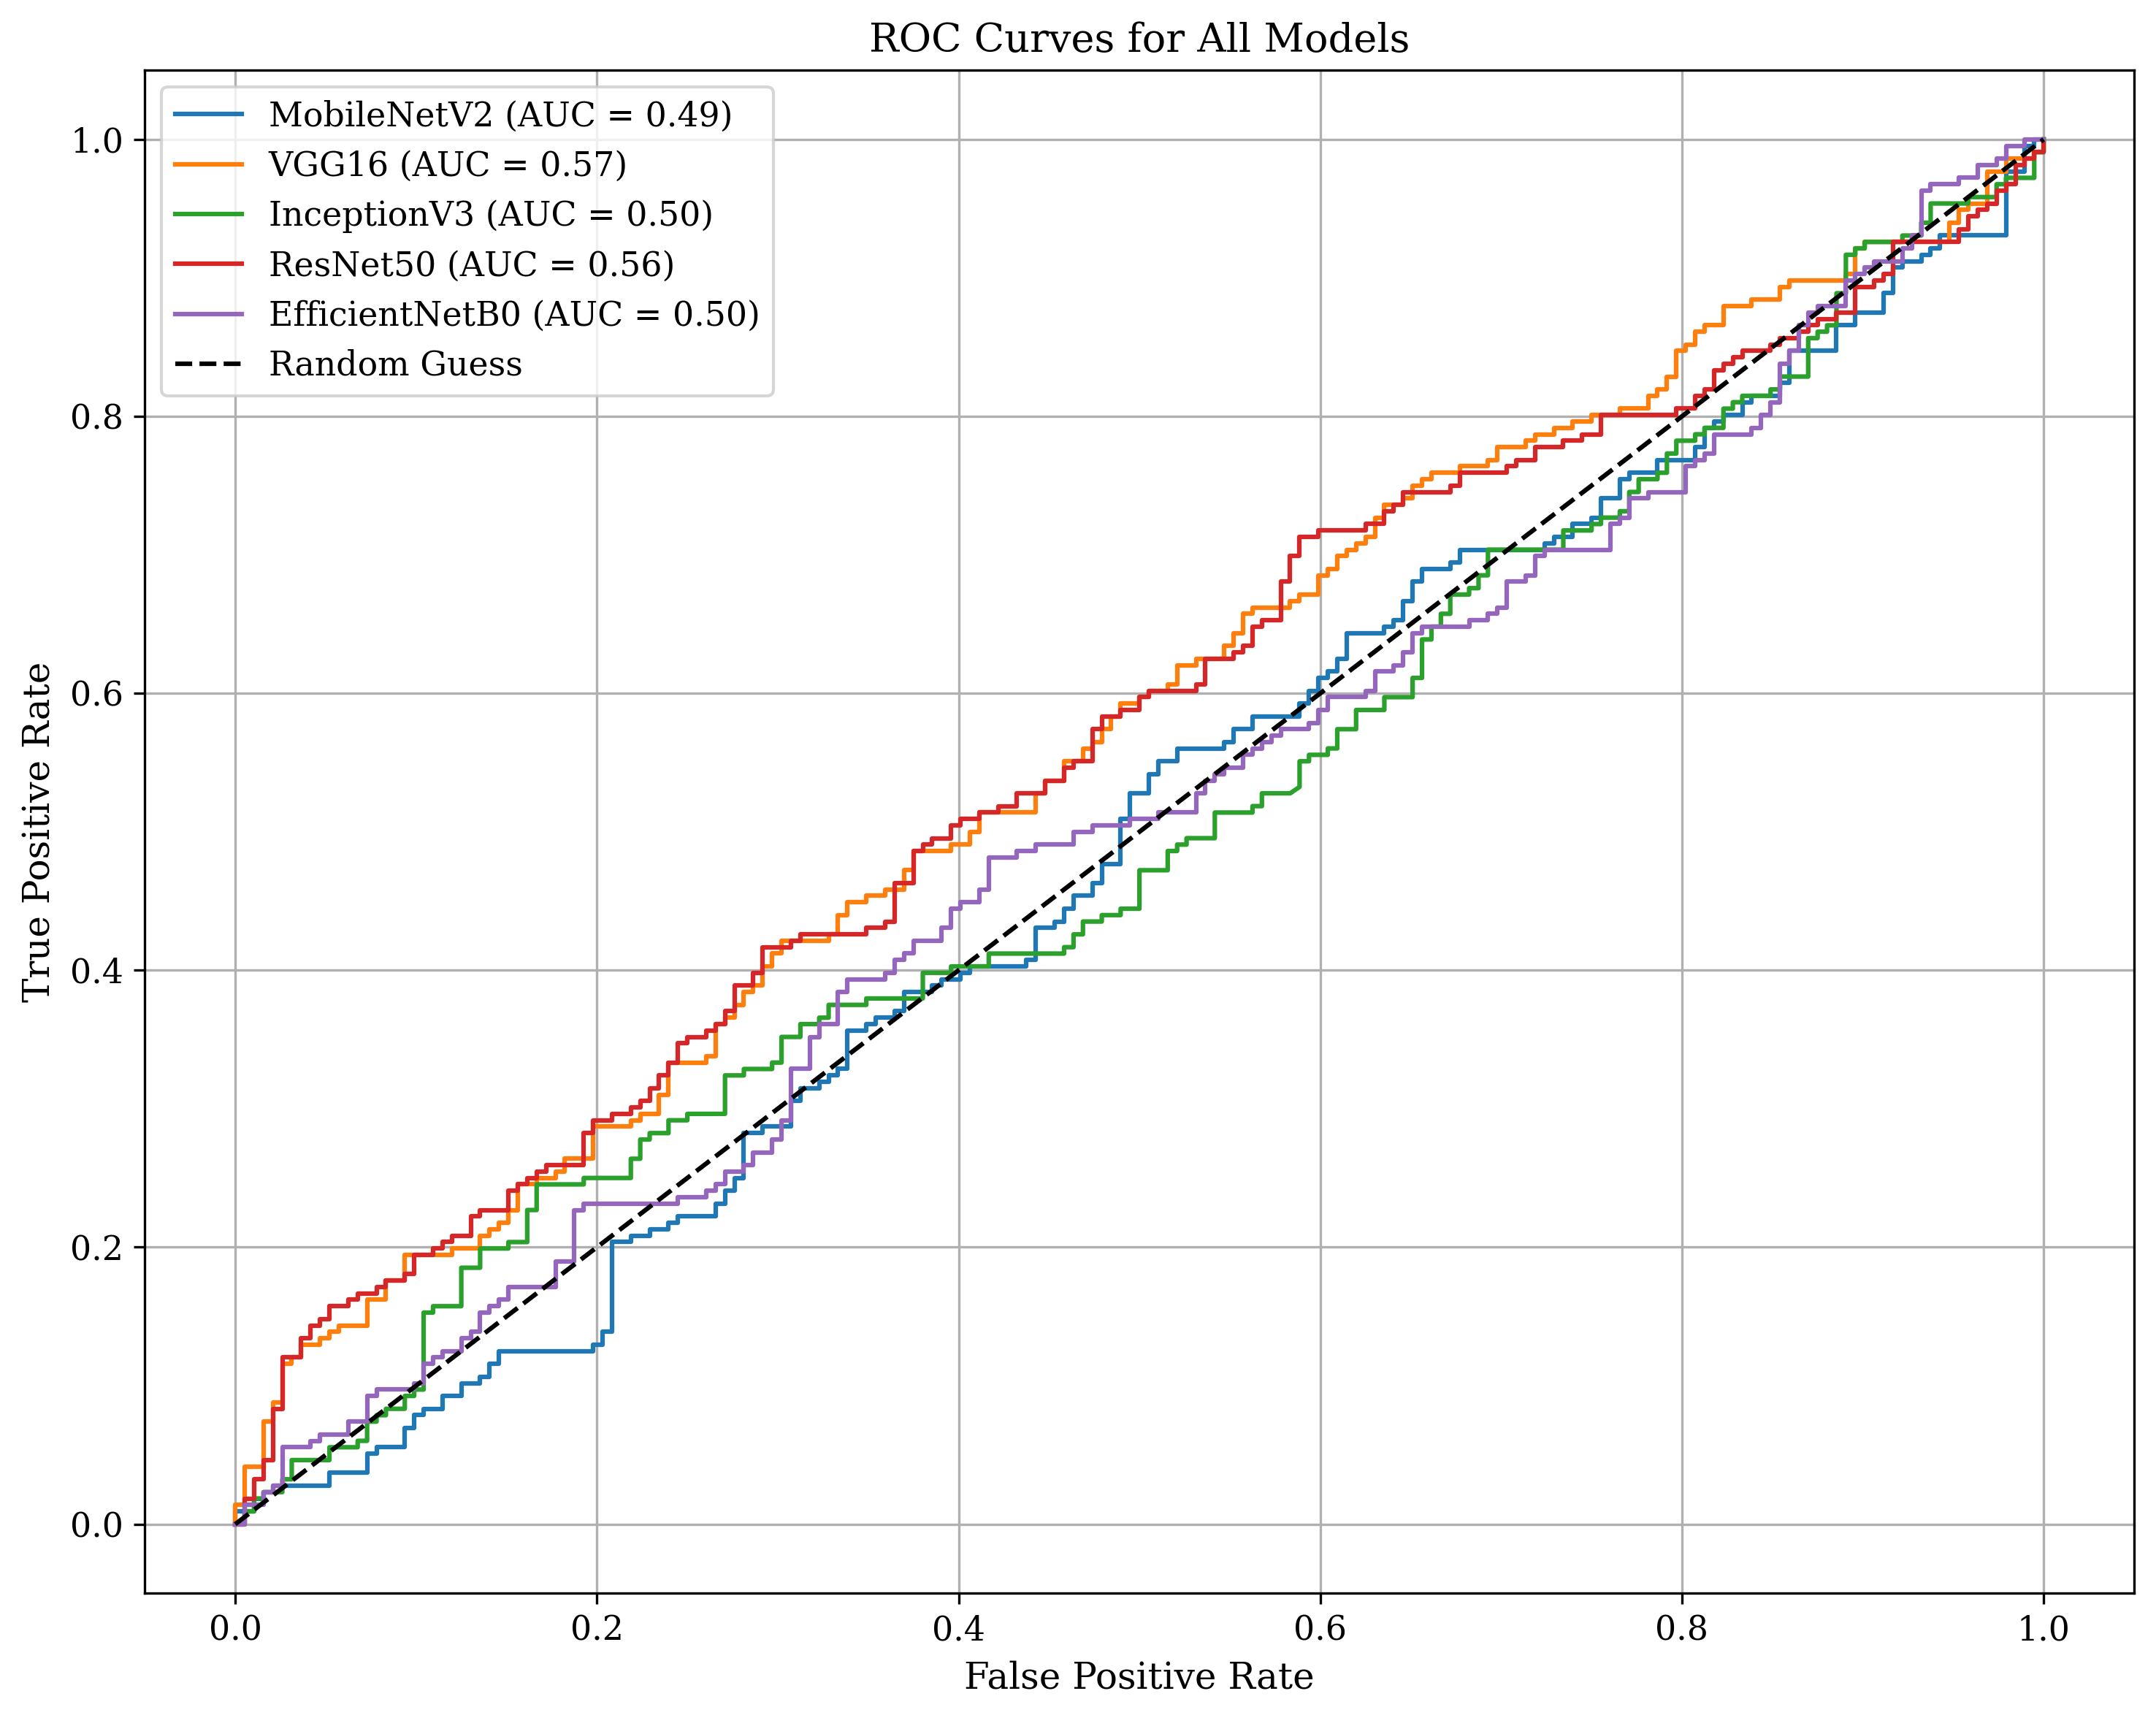

In [18]:
plt.figure(figsize=(10, 8))
for name in model_names:
    fpr, tpr, roc_auc = roc_data[name]
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    print(f"{name}: {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'roc_curve.png')
plt.show()


## 6c. Confusion Matrices

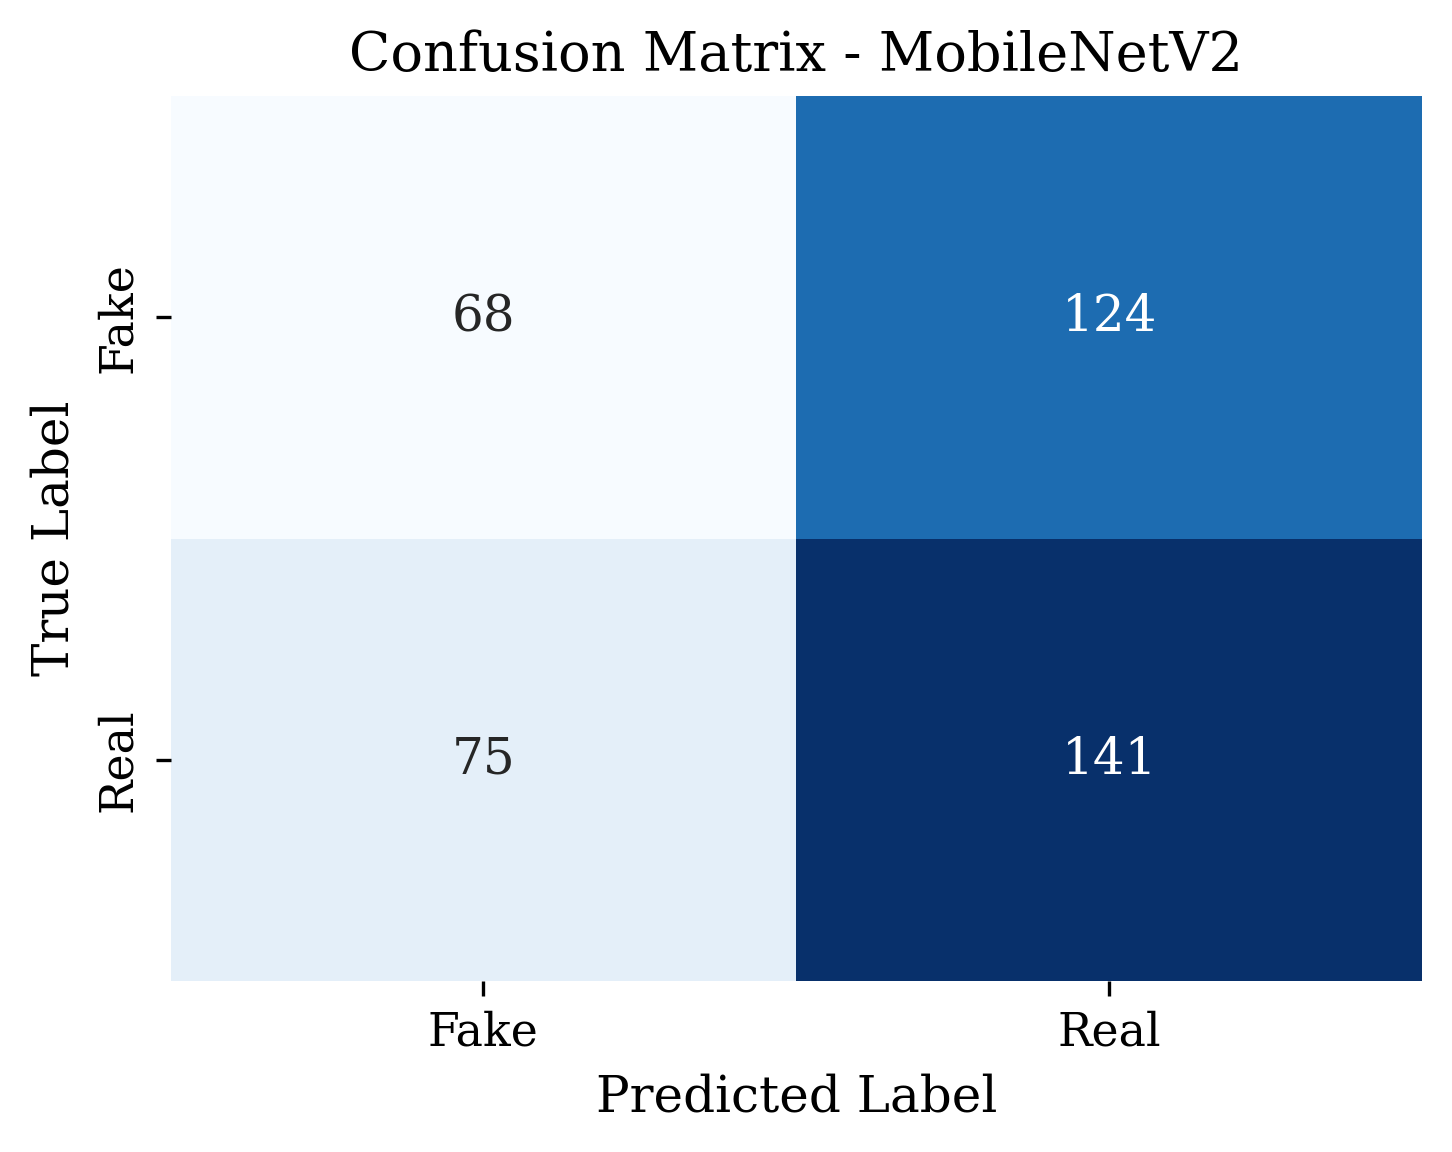

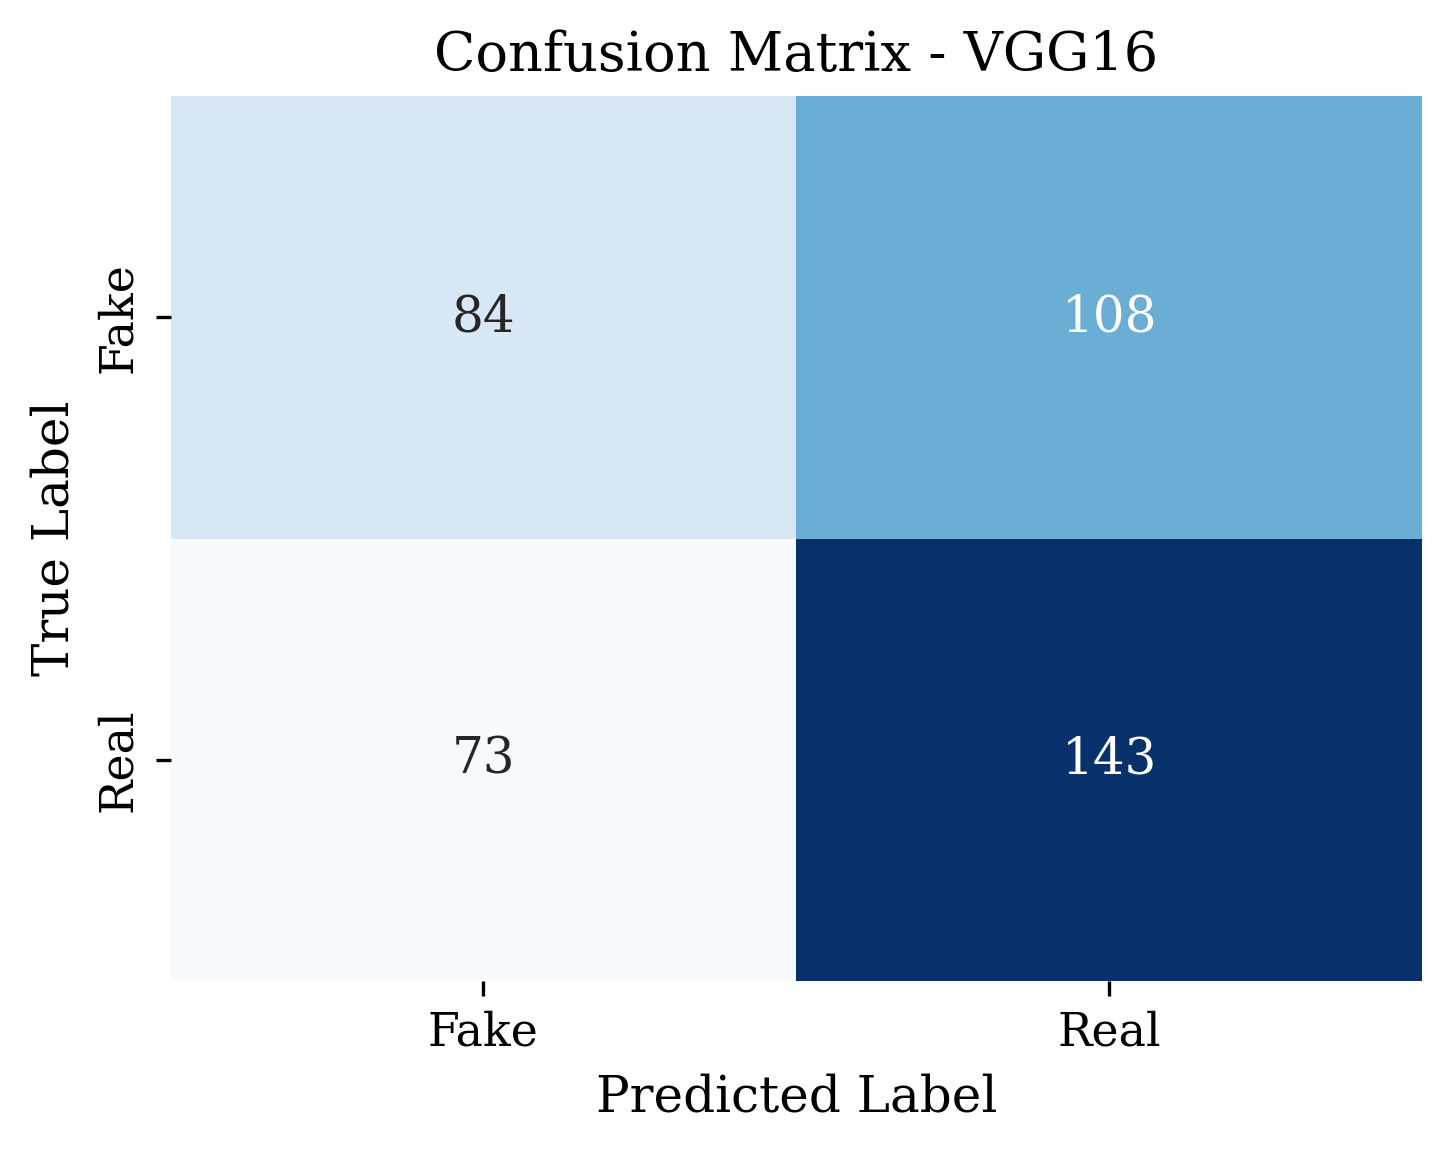

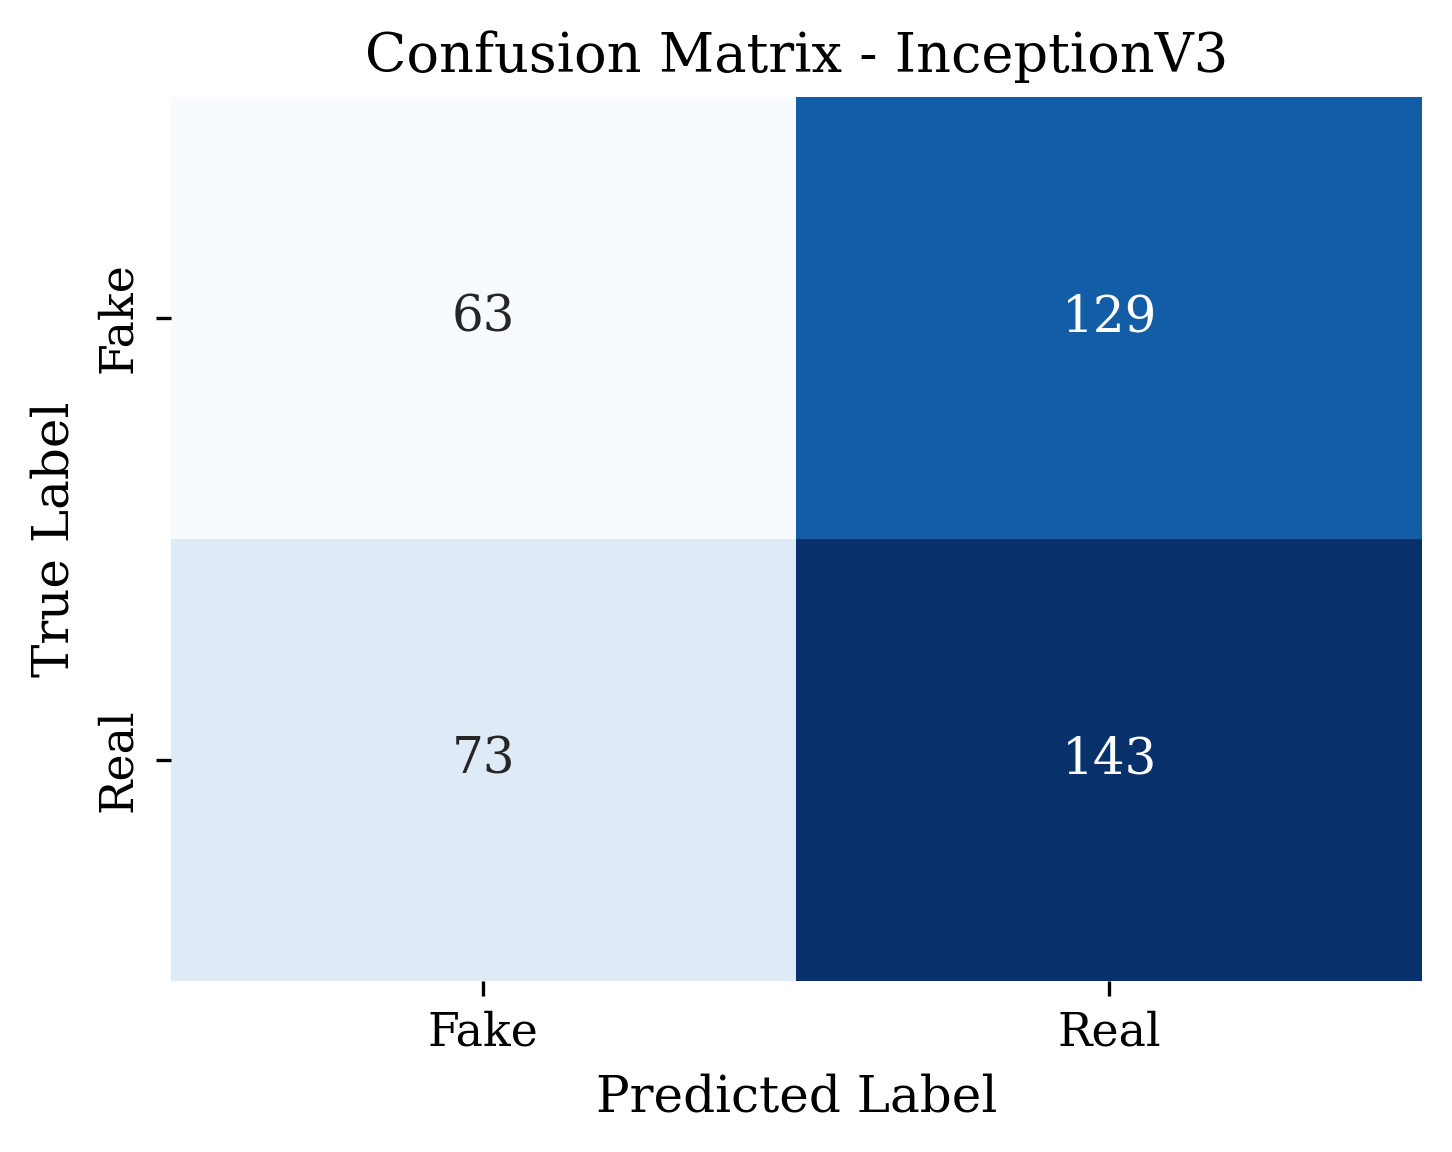

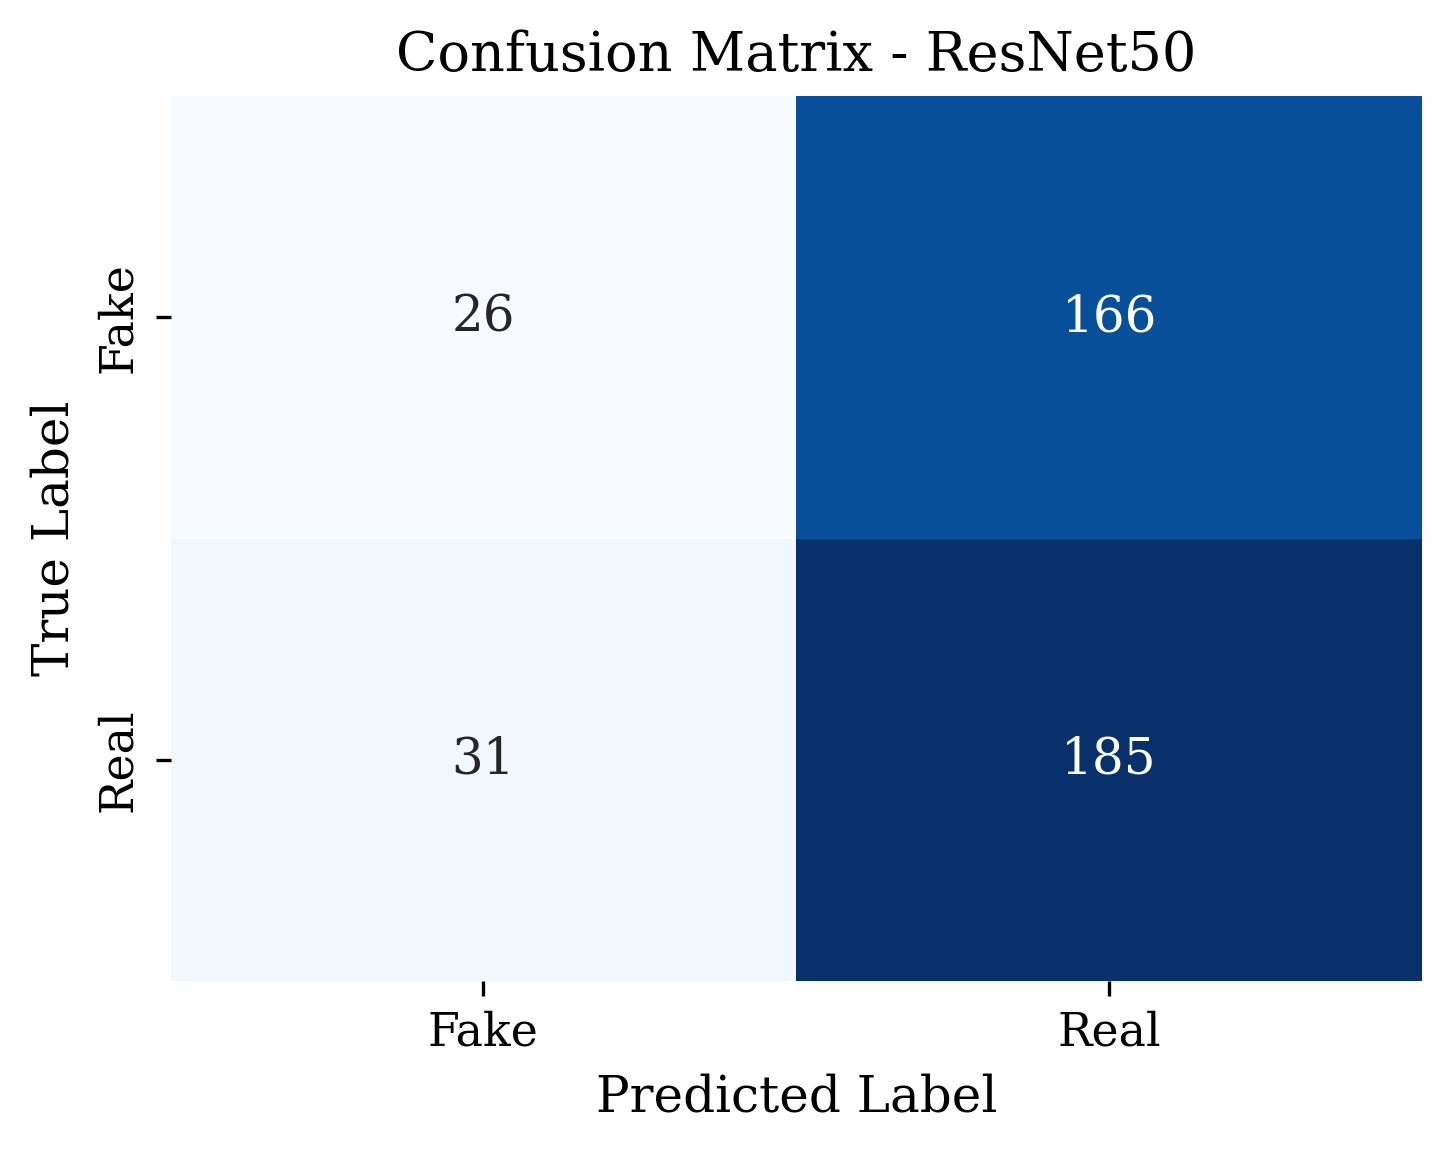

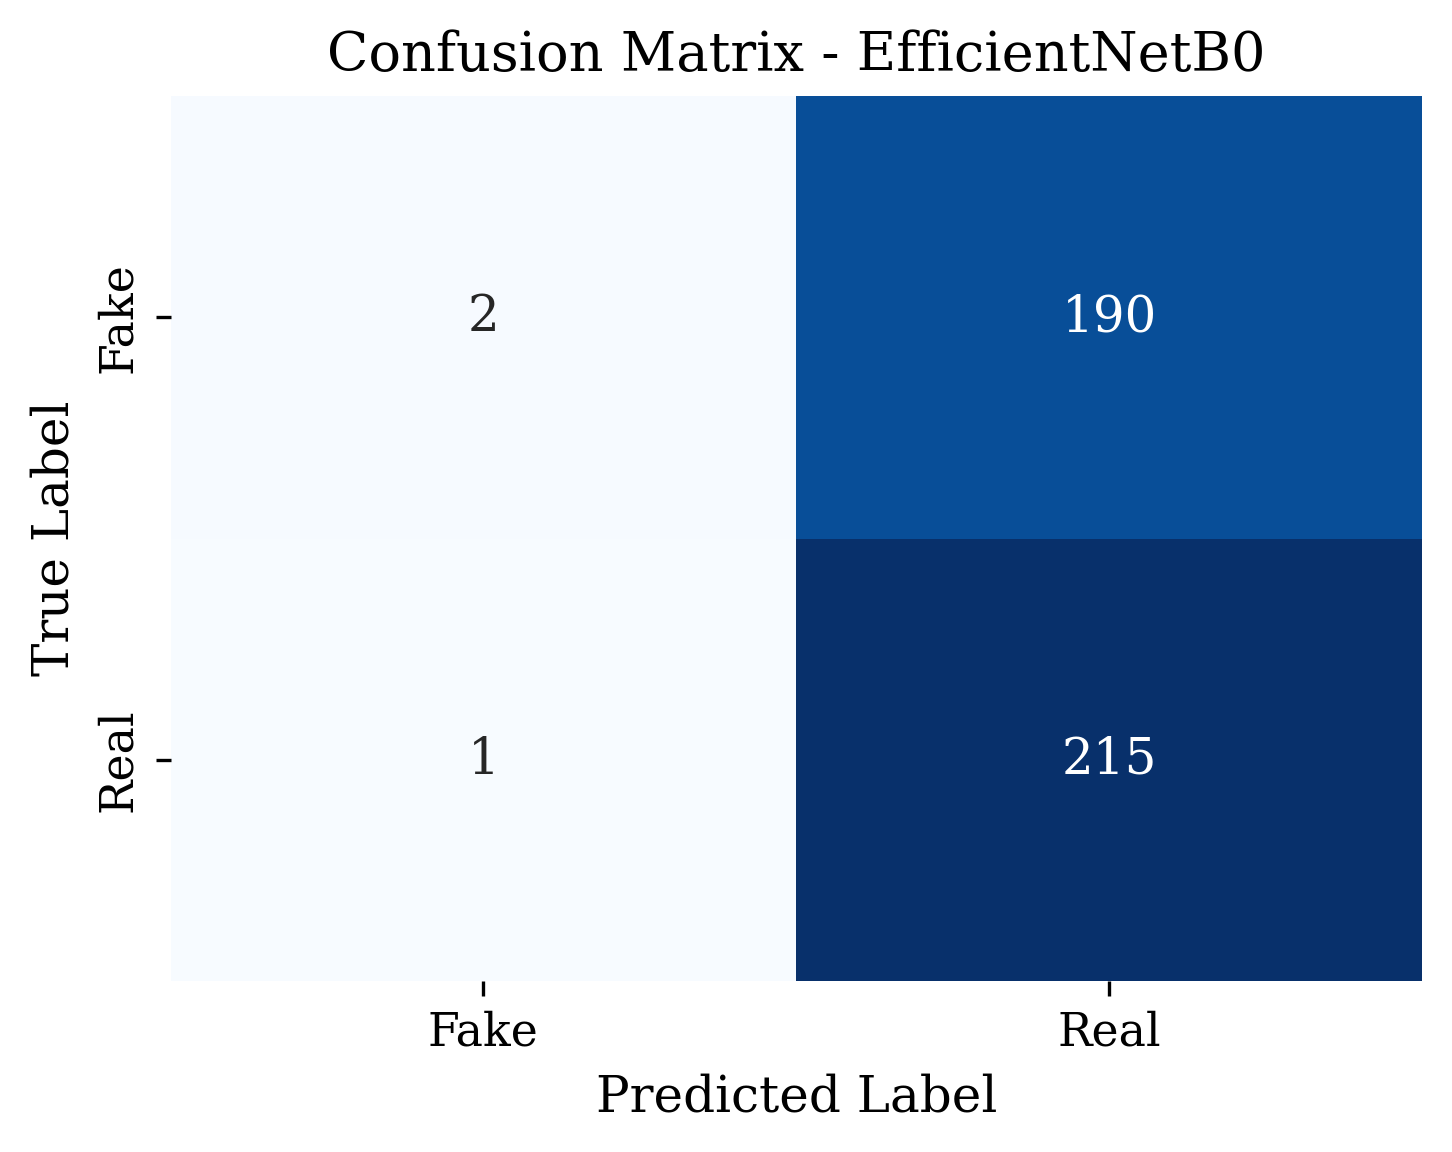

In [14]:
for name in model_names:
    cm = conf_matrices[name]
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'{name.lower()}_confusion_matrix.png')
    plt.show()


# 7- Model Comparison

## 7a. Train-Val Accuracy

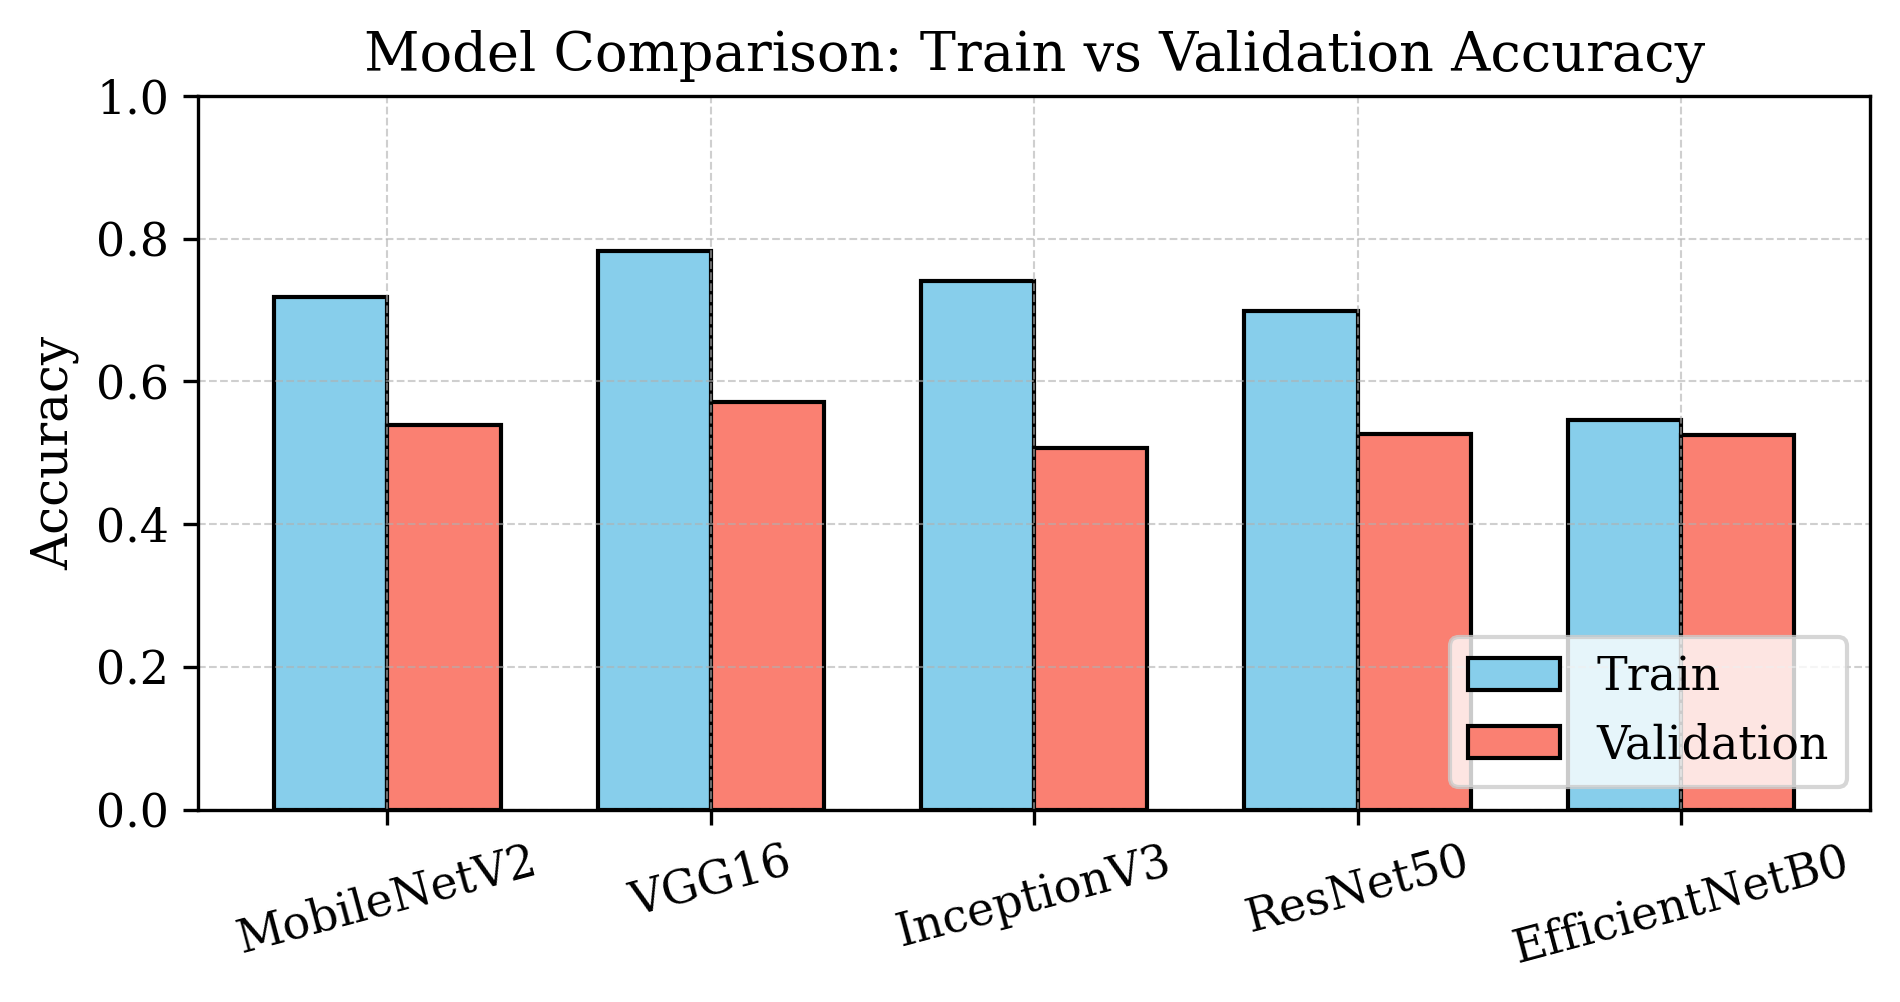

In [6]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 300,
    "savefig.dpi": 300
})

train_accuracies = [results[m]['train_accuracy'] for m in model_names]
val_accuracies = [results[m]['val_accuracy'] for m in model_names]
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(6.5, 3.5))
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, val_accuracies, width, label='Validation', color='salmon', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15)
ax.set_ylim(0, 1)
ax.set_ylabel("Accuracy")
ax.set_title(r"Model Comparison: Train vs Validation Accuracy")
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.savefig("/kaggle/working/model_comparison.jpg", format='jpg')
plt.show()


## 7b. Train-Val Loss

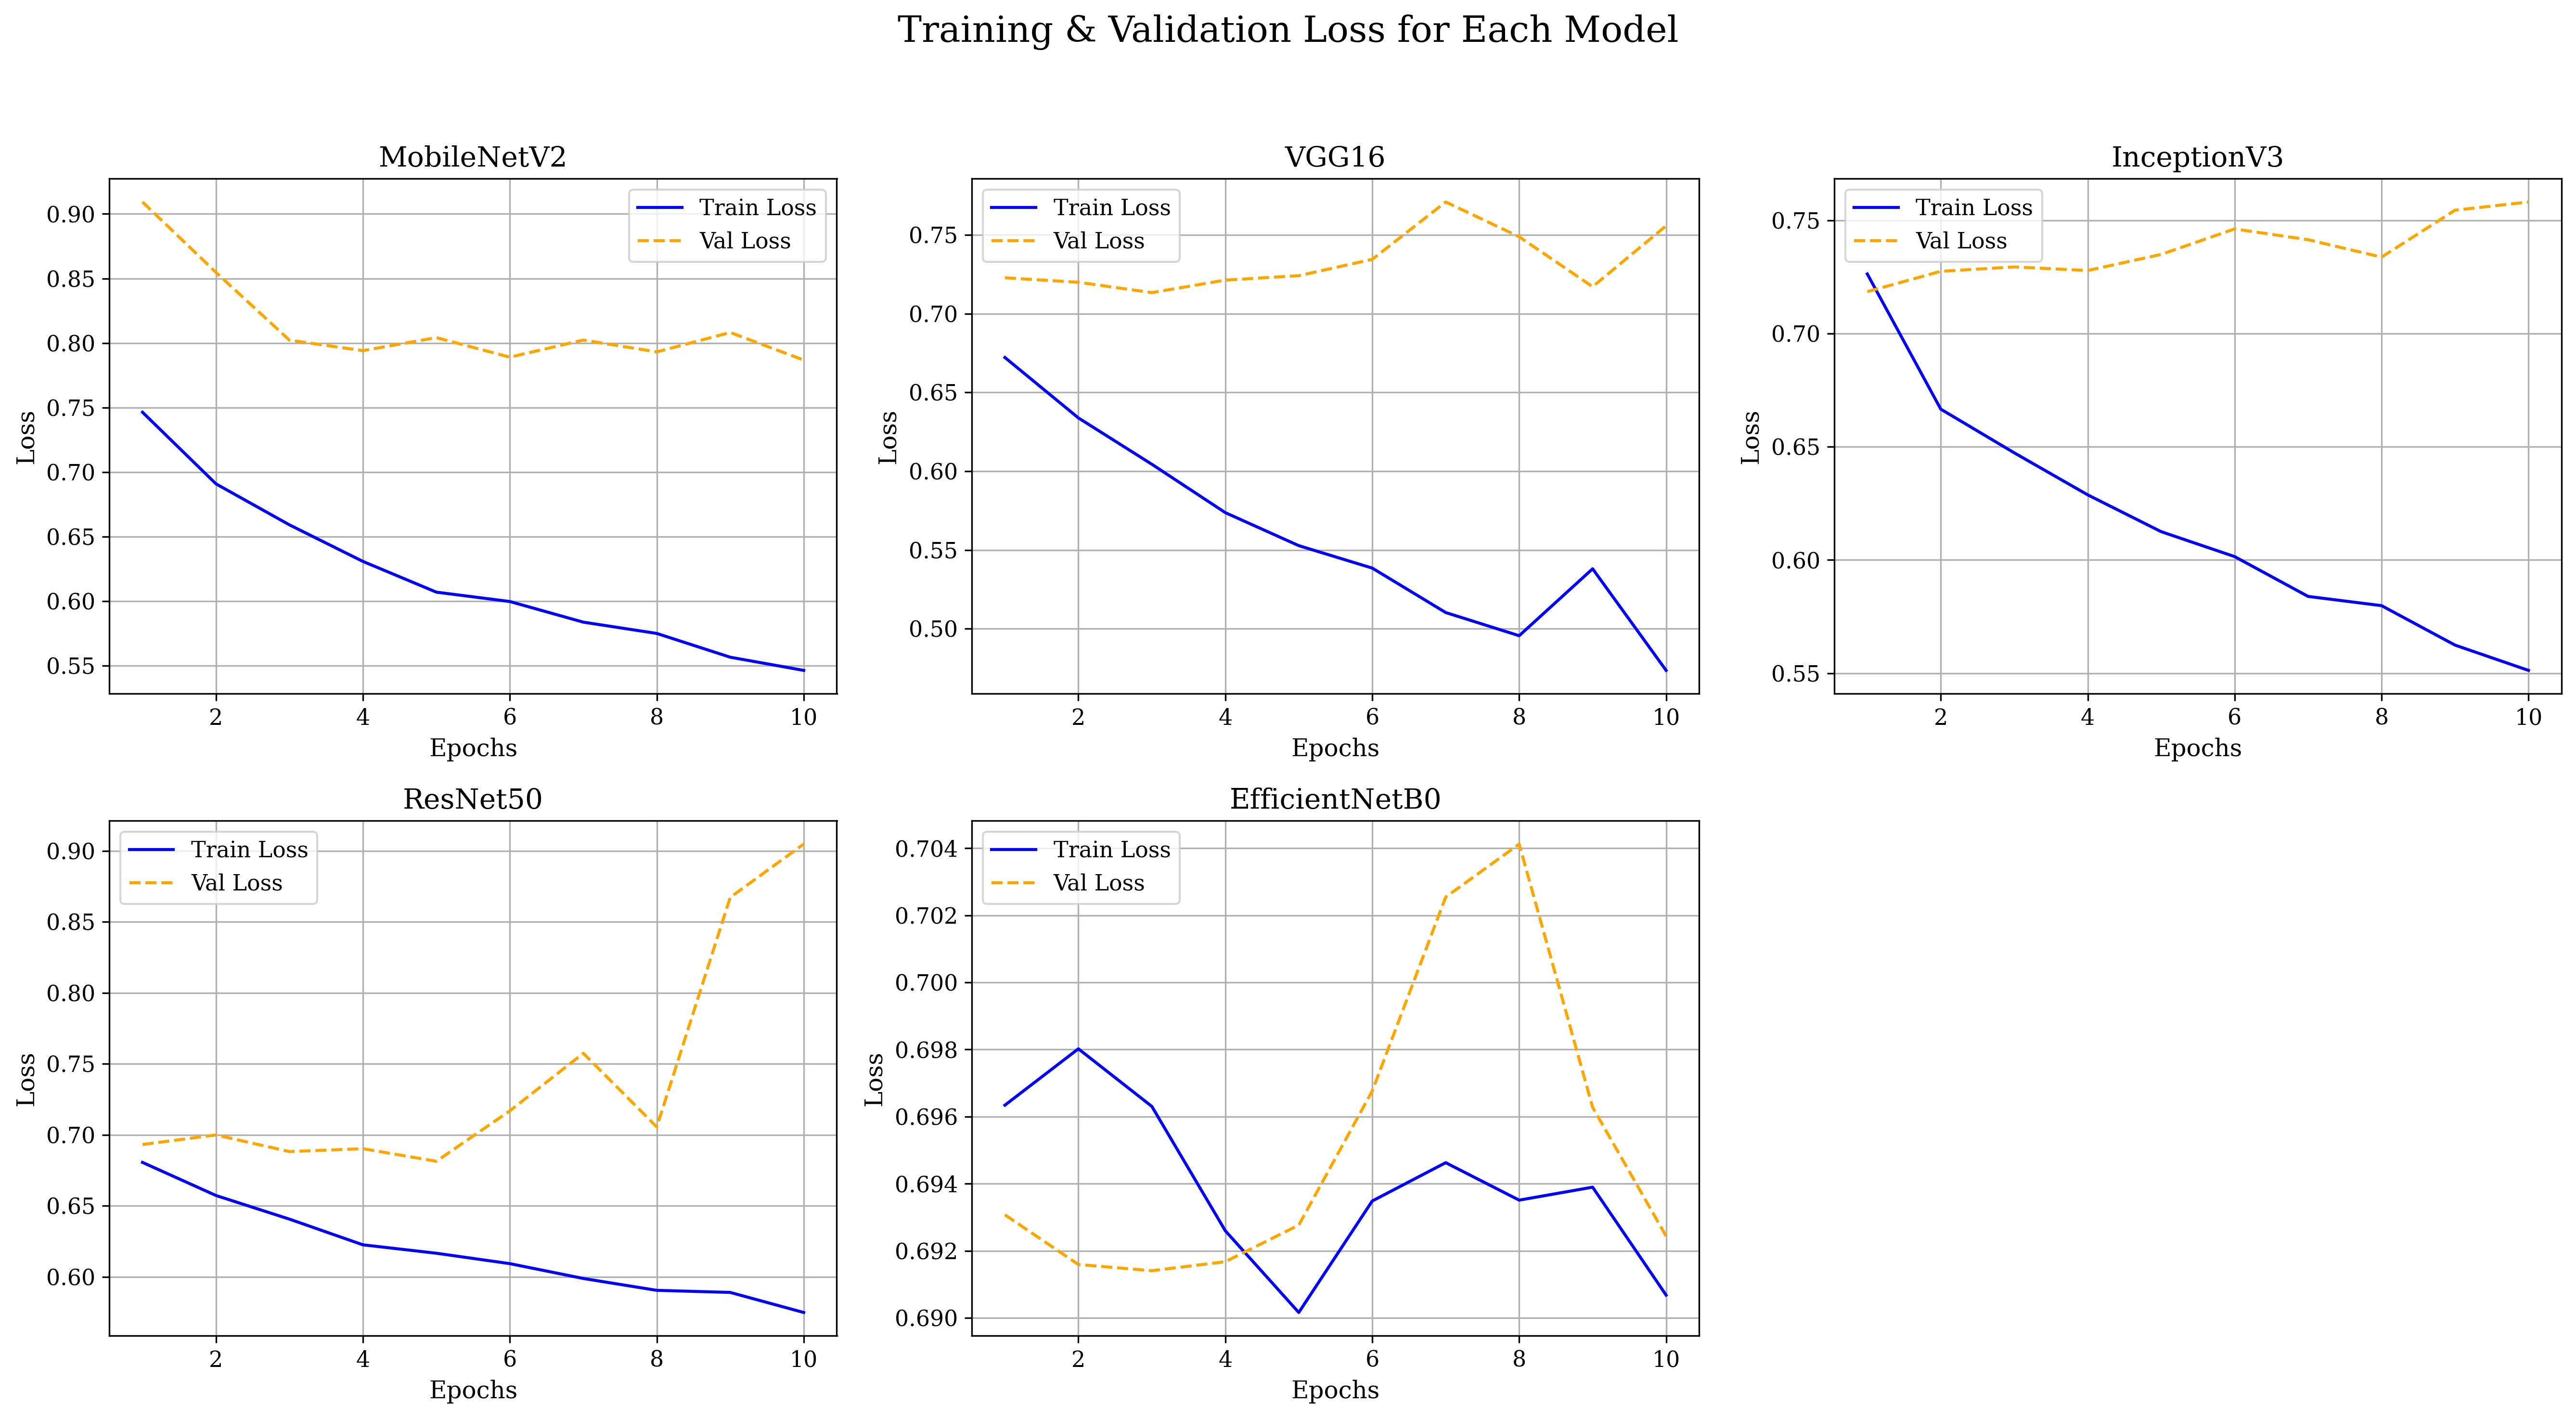

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) 
axes = axes.flatten()

for idx, name in enumerate(model_names):
    history = histories[name]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(loss) + 1)

    ax = axes[idx]
    ax.plot(epochs_range, loss, label='Train Loss', color='blue')
    ax.plot(epochs_range, val_loss, label='Val Loss', color='orange', linestyle='--')
    ax.set_title(f"{name}", fontsize=14)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

for j in range(len(model_names), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Training & Validation Loss for Each Model", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
